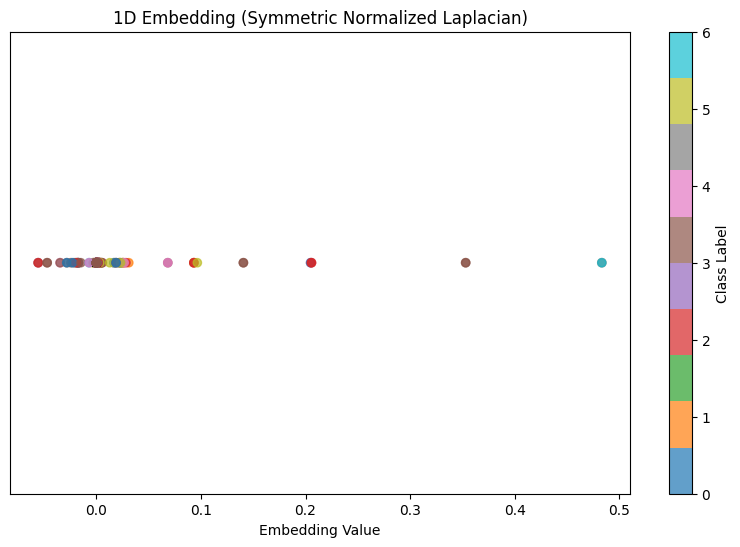

1D Embedding (Normalized Laplacian):
Mean Accuracy: 0.3177
Variance of Accuracy: 0.0003


<ipython-input-9-1fabb3c92413>:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


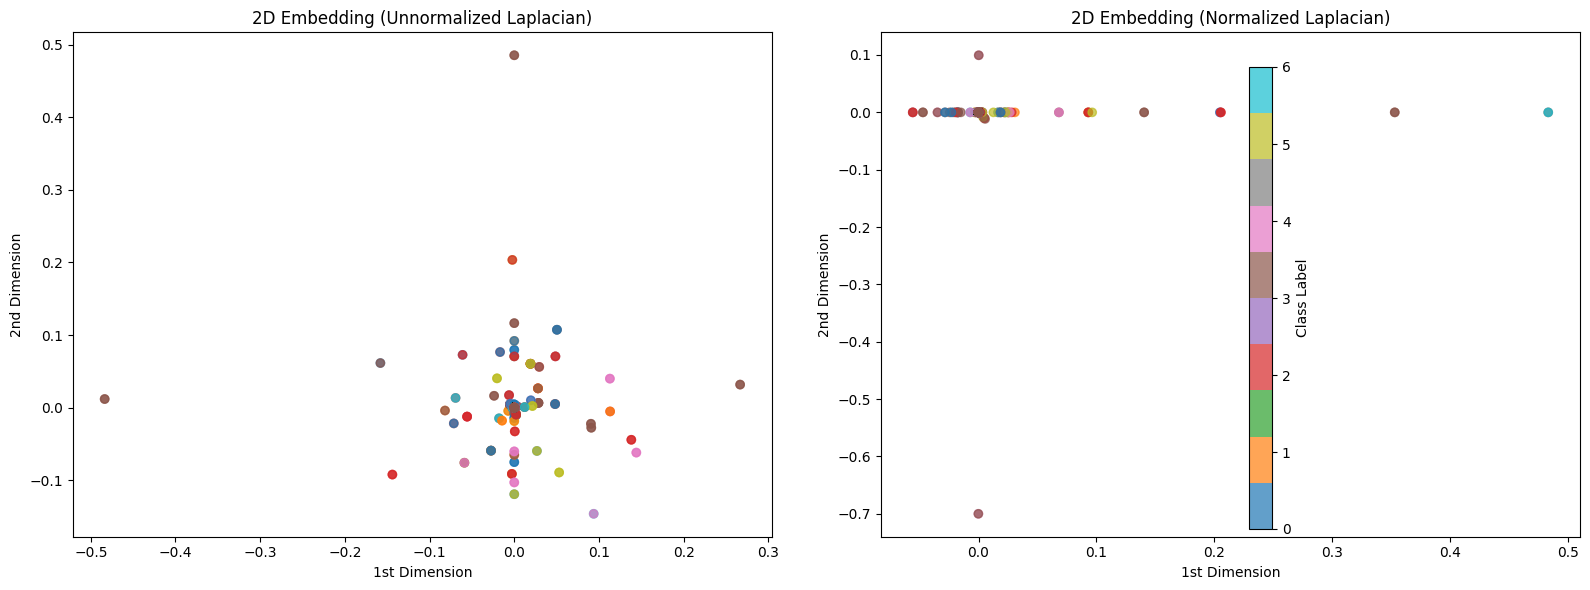

k-Dimensional Embedding Classification Results:
k=2: Mean Accuracy = 0.2989, Variance = 0.0002
k=5: Mean Accuracy = 0.2923, Variance = 0.0003
k=10: Mean Accuracy = 0.3137, Variance = 0.0002


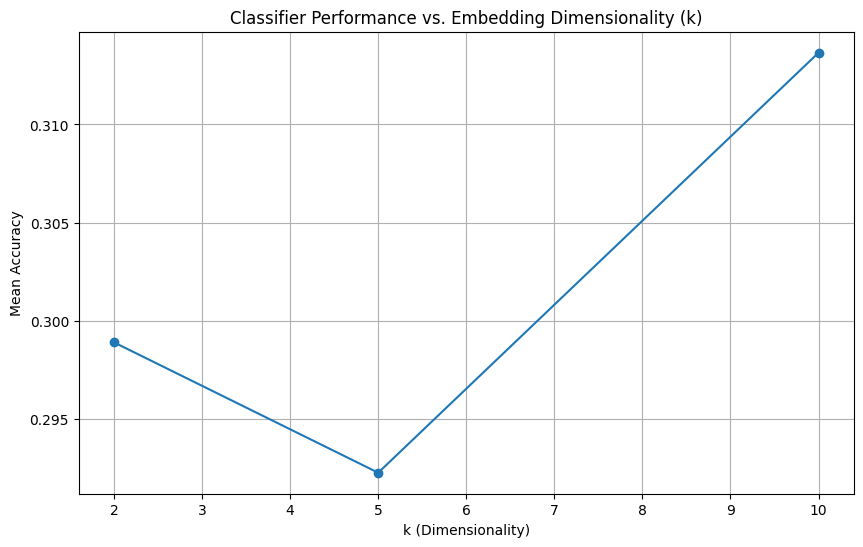

In [9]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

# Load the graph data
graph_file_path = 'graph.csv'
graph_data = pd.read_csv('graph.csv', header=None)
graph_data.columns = ['source', 'target']

# Load node labels
nodelabels_file_path = 'nodelabels.csv'
node_labels = pd.read_csv('nodelabels.csv', header=None).squeeze("columns")

# Create the graph
G = nx.from_pandas_edgelist(graph_data, source='source', target='target')

# Compute adjacency matrix and degree matrix
adj_matrix = nx.adjacency_matrix(G).astype(float).toarray()
degree_matrix = np.diag(adj_matrix.sum(axis=1))

# Compute Laplacian matrices
L = degree_matrix - adj_matrix  # Unnormalized Laplacian
D_sqrt_inv = np.linalg.inv(np.sqrt(degree_matrix))
L_sym = np.eye(len(G)) - D_sqrt_inv @ adj_matrix @ D_sqrt_inv  # Normalized Laplacian

# Function to compute embeddings based on eigenvectors of Laplacian matrices
def compute_embeddings(Laplacian, k):
    eigenvalues, eigenvectors = np.linalg.eigh(Laplacian)
    # Exclude the smallest eigenvalue (corresponding to the trivial solution)
    return eigenvectors[:, 1:k + 1]

# (b) One-dimensional embedding using normalized Laplacian
embedding_1d_sym = compute_embeddings(L_sym, 1).flatten()

# Visualize 1D embedding with colors representing classes
plt.figure(figsize=(10, 6))
scatter = plt.scatter(embedding_1d_sym, np.zeros_like(embedding_1d_sym), c=node_labels, cmap="tab10", alpha=0.7)
plt.colorbar(scatter, label="Class Label")
plt.title("1D Embedding (Symmetric Normalized Laplacian)")
plt.xlabel("Embedding Value")
plt.yticks([])
plt.show()

# Train-test split and classification
accuracies = []
for _ in range(5):
    X_train, X_test, y_train, y_test = train_test_split(embedding_1d_sym.reshape(-1, 1), node_labels, test_size=0.2)
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

mean_accuracy = np.mean(accuracies)
var_accuracy = np.var(accuracies)

print("1D Embedding (Normalized Laplacian):")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Variance of Accuracy: {var_accuracy:.4f}")

# (c) Two-dimensional embeddings
embedding_2d = compute_embeddings(L, 2)
embedding_2d_sym = compute_embeddings(L_sym, 2)

# Visualize 2D embeddings
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for L
scatter = axes[0].scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=node_labels, cmap="tab10", alpha=0.7)
axes[0].set_title("2D Embedding (Unnormalized Laplacian)")
axes[0].set_xlabel("1st Dimension")
axes[0].set_ylabel("2nd Dimension")

# Plot for L_sym
scatter = axes[1].scatter(embedding_2d_sym[:, 0], embedding_2d_sym[:, 1], c=node_labels, cmap="tab10", alpha=0.7)
axes[1].set_title("2D Embedding (Normalized Laplacian)")
axes[1].set_xlabel("1st Dimension")
axes[1].set_ylabel("2nd Dimension")

plt.colorbar(scatter, ax=axes, label="Class Label")
plt.tight_layout()
plt.show()

# (d) k-dimensional embeddings and classifier performance
ks = [2, 5, 10]
classifier_accuracies = {k: [] for k in ks}

for k in ks:
    embedding_k = compute_embeddings(L_sym, k)  # Using normalized Laplacian based on previous findings
    for _ in range(5):
        X_train, X_test, y_train, y_test = train_test_split(embedding_k, node_labels, test_size=0.2)
        clf = LogisticRegression(max_iter=1000)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        classifier_accuracies[k].append(accuracy_score(y_test, y_pred))

# Report results
print("k-Dimensional Embedding Classification Results:")
for k, accs in classifier_accuracies.items():
    print(f"k={k}: Mean Accuracy = {np.mean(accs):.4f}, Variance = {np.var(accs):.4f}")

# Visualize accuracy as a function of k
mean_accuracies = [np.mean(classifier_accuracies[k]) for k in ks]
plt.figure(figsize=(10, 6))
plt.plot(ks, mean_accuracies, marker="o")
plt.title("Classifier Performance vs. Embedding Dimensionality (k)")
plt.xlabel("k (Dimensionality)")
plt.ylabel("Mean Accuracy")
plt.grid(True)
plt.show()
